<a href="https://colab.research.google.com/github/ITU-Business-Analytics-Team/Business_Analytics_for_Professionals/blob/main/Part%20II%20%3A%20Business%20Applications/Chapter%2011%3A%20Supply%20Chain%20Analytics/11_3_Inventory_Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Supply Chain Analytics**
## Inventory Management

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
from fbprophet import Prophet
import matplotlib.pyplot as plt

In [ ]:
# Import Data

url = "https://docs.google.com/spreadsheets/d/18c9J9nSVYb59ALa7JioC1YLgoKVRyQhz/edit?usp=sharing&ouid=108589602591644119588&rtpof=true&sd=true"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
df = pd.read_excel(path)
df.head()

,Week,Year,Price,Demand,Free,Percent,MinTemp,MaxTemp,Precipitation,PriceNextWeek,NextWeekFree,NextWeekPercent,Holiday,SchoolHoliday,NextWeekHoliday
0,27,2019,3.50000,130,0,0,16.5,32.8,6.5,3.50000,0,0,0,1,0
1,28,2019,3.50000,146,0,0,16.5,30.7,3.7,3.50000,0,0,0,1,1
2,29,2019,3.50000,140,0,0,19.6,32.8,5.7,3.59375,0,0,1,1,0
3,30,2019,3.59375,119,0,0,21.9,33.6,0.0,3.71875,0,0,0,1,0
4,31,2019,3.71875,166,0,0,20.1,32.1,0.0,3.71875,0,0,0,1,1


There are 26 observations and 15 attributes. The aim is to forecast demand value and use other columns as exogenous variable. List of variables and their definitions are listed below:

Variable Name  | Variable Description 
-------------------|------------------
Week       | The week number of the year 
Year       | Year 
Price       |Price of one unit of beverage for that week
Demand       |Demand of beverage for that week
Percent       |How many days free product campaign was made for that week
MinTemp       |Minimum temperature for that week
MaxTemp       |Maximum temperature for that week
Precipitation       |Total precipitation for that week
NextWeekPrice       |Price of one unit of beverage for next week
NextWeekFree       |How many days free product campaign was made for next week
NextWeekPercent      |How many days discounted product campaign was made for next week
Holidays      |Number of holidays for that week
SchoolHolidays       |Number of school holidays for that week
NextHoliday       |Number of holidays for next week


Next, create date-time variable from `Week` and `Year` variables.


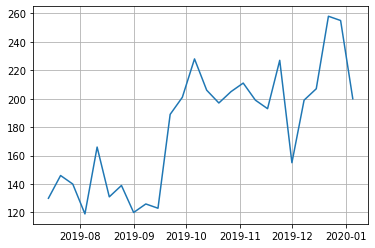

In [ ]:
date_fmt = df.Year*1000 + df.Week*10
df["Date"] = pd.to_datetime(date_fmt, format="%Y%W%w")

plt.plot(df.Date,df.Demand)
plt.grid()

We need to provide a dataframe as input for `Prophet` model. In the dataframe there should be a date-time column names as `ds` and values should be names as `y`. We are going to add other variables as exogenous variables.

In [ ]:
df.rename({"Demand":"y","Date":"ds"},axis = 1, inplace=True)
cols = list(df.columns)
# Columns except Week, Year, y and ds will be used as exogenous variables.
[cols.remove(i) for i in ["Week","Year","y","ds"]]

[None, None, None, None]

Last 6 weeks will be used for training and others will be used for testing.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


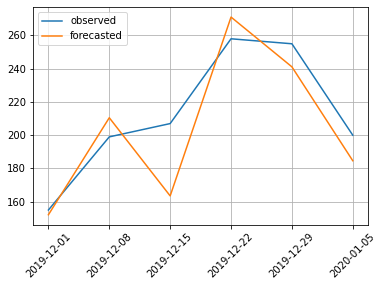

In [ ]:
period = 6
df_train = df.iloc[:-period,:]
df_test = df.iloc[-period:,:]
mdl = Prophet(weekly_seasonality=False)
for col in cols:
    mdl.add_regressor(col)
mdl.fit(df_train)
ypred = mdl.predict(df_test)

plt.plot(df_test.ds,df_test.y, label = "observed")
plt.plot(df_test.ds,ypred.yhat, label = "forecasted")
plt.grid()
plt.xticks(df_test.ds,rotation=45)
plt.legend()

In [ ]:
demand = ypred.yhat.astype("int")
unit_cost = 10
order_cost = 100
holding_cost = 0.5

In [ ]:
def print_df(demand,orders,holding_cost,order_cost):
    period = np.arange(1,demand.size + 1)
    ending_inv = np.cumsum(orders - demand)
    begin_inv = np.roll(ending_inv,1)
    begin_inv[0] = 0

    df = pd.DataFrame({"Period":period,
                "Beginning Inventory": begin_inv,
                "Demand":demand,
                "Orders":orders,
                "Ending Inventory":ending_inv,
               # "Holding Cost(per unit per period)":holding_cost,
                #"Order Cost (per order)":order_cost,
                "Holding Cost": holding_cost*begin_inv,
                "Order Cost": order_cost*(orders > 0)})
    
    return df

#print_df(demand,orders,holding_cost,order_cost)

In [ ]:
def order_sizes(order_points,demand):
    orders = np.zeros(demand.size)
    ix2 = demand.size
    ix1 = order_points[-1]
    while True:
        orders[ix1] = np.sum(demand[ix1:ix2])
        ix1, ix2 = order_points[ix1-1], ix1
        if ix2 == 0:
            break
    return orders
#orders = order_sizes(order_points,demand)

In [ ]:
def find_min(demand,last_order,t,order_cost,holding_cost,min_costs):
    if t == 0:
        return order_cost, 0
    else:
        cost = []
        for i in range(last_order, t+1):
            oc = order_cost
            hc = np.sum(holding_cost*np.arange(1,t-i+1)*demand[i+1:t+1])
            if i == 0:
                cost.append(oc + hc)
            else:
                cost.append(min_costs[i-1] + oc + hc)
        return np.min(cost), np.argmin(cost)+last_order

**Fixed Order Quantity**: It specifies an arbitrary number of units to be ordered in each time. For instance, economic order quantity can be used to as a fixed-order quantity for each period. In our case, we used economic order quantity as a fixed order quantity per period.

**EOQ (Economic Order Quantity)**: The economic order quantity (EOQ) is a widely used model in inventory control settings. The aim is to decide when and how much inventory should be replenished in order to minimize the sum of the costs (holding cost, ordering cost, and unit cost) per unit time.  The model is as follows: 

$$EOQ=\sqrt{\frac{2DS}{H}}$$ 
where D indicates the annual demand, S indicates the ordering cost (setup cost), and H indicates the holding (carrying) cost on an annual basis per unit. The order size for each period is indicated by the EOQ.


In [ ]:
def FOQ(demand, holding_cost, order_cost):
    #Input Parameters:
    #demand: annual quantity demanded (in our case six-weeks total demand)
    #order_cost: ordering cost    
    #holding_cost: holding cost per unit    
    #Outputs:Fixed order quantity for each week 
    #Fixed order quantity: EOQ is used as a fixed order quantity. Replenishment takes place when the beginning inventory of a week does not meet the demand of that week.
  
    average_demand = np.average(demand)
    EOQ = int(np.sqrt(2*average_demand*order_cost/holding_cost))  
    current_inventory = 0
    order_quantity = np.zeros(len(demand))
    total_carrying_cost = np.zeros(len(demand))
    order_quantity[0] = EOQ
    current_inventory = order_quantity[0]- demand[0] 
    for i in range(1, len(demand)):   
         #current_inventory += order_quantity[i]- demand[i]   
         if (current_inventory>0):
            total_carrying_cost[i] = holding_cost*current_inventory 
         if (current_inventory-demand[i]>=0): 
            order_quantity[i] = 0
            current_inventory -=demand[i]
         else:
           if(EOQ+current_inventory-demand[i]>=0):
             order_quantity[i] = EOQ
             current_inventory+=EOQ-demand[i]
           else:
             order_quantity[i] = 2*EOQ
             current_inventory+=order_quantity[i]-demand[i]
            
    
    total_cost = sum(total_carrying_cost)+ order_cost*np.count_nonzero(order_quantity) 
    display(print_df(demand,order_quantity,holding_cost,order_cost))
    return(order_quantity, total_cost)

FOQ(demand, holding_cost, order_cost)

,Period,Beginning Inventory,Demand,Orders,Ending Inventory,Holding Cost,Order Cost
0,1,0.0,152,285.0,133.0,0.0,100
1,2,133.0,210,285.0,208.0,66.5,100
2,3,208.0,163,0.0,45.0,104.0,0
3,4,45.0,271,285.0,59.0,22.5,100
4,5,59.0,241,285.0,103.0,29.5,100
5,6,103.0,184,285.0,204.0,51.5,100


(array([285., 285.,   0., 285., 285., 285.]), 774.0)

**Part Period Balancing (PPB)**: PPB aims to balance the inventory-carrying cost and setup cost. The objective is to keep the inventory holding costs close to the ordering costs as possible.  The following describes how the technique works:

Let
$d_1,d_2,d_3,…,d_n$  be the demand for an item over a period of n periods: \\
$O$: be the ordering cost \\
$H$: be the holding cost for an item per period \\
$C(j)$: be the total holding cost over j period \\
$C(j)=Hd_2+2Hd_3+⋯+(j-1)Hd_j$ \\
$y_1,y_2,y_3  ..,y_n$ be the order size over a period of $n$ periods \\

The steps of the method are as follows: \\

- Start with $t=1$ 
- Step I: Start the calculation from period t* to next period. Calculate $C(t),C (t+1),..,C(j)$ until $C(j)>O/H$
- Step II: If $C(j)>O/H$ set $y_t= d_t+d_{t+1}+⋯+d_{j-1}$ 
- Step III: Go to Step I and start over period $j$ 
- Step IV: Repeat step (I-III) until $y_1+y_2+⋯+y_n>= d_1+d_2+⋯+d_n$



In [ ]:
def PPB(demand, holding_cost, order_cost):
    #Input Parameters:
    #demand: annual quantity demanded (in our case six-weeks total demand)
    #order_cost: ordering cost    
    #holding_cost: holding cost per unit    
    #Outputs: Order quantity for each week

    order_quantity = np.zeros(len(demand))
    PPF = order_cost/holding_cost
    PP_cost = np.zeros(len(demand))
    flag = True
    flag2 = True
    index = 0
    
    while flag2:
        flag = True
        while flag:
            for i in range(index, len(demand)):        
               PP_cost[index] += (i-index)*demand[i]*holding_cost
               order_quantity[index] +=demand[i] 
               if(PP_cost[index]>=PPF):
                   flag = False
                   index = i+1
               if(sum(order_quantity)>=sum(demand)):
                   flag = False
                   flag2 = False
        
        if(index>=len(demand) or sum(order_quantity)>sum(demand)):
            
            flag2 = False
    display(print_df(demand,order_quantity,holding_cost,order_cost))

PPB(demand, holding_cost, order_cost)

,Period,Beginning Inventory,Demand,Orders,Ending Inventory,Holding Cost,Order Cost
0,1,0.0,152,525.0,373.0,0.0,100
1,2,373.0,210,0.0,163.0,186.5,0
2,3,163.0,163,0.0,0.0,81.5,0
3,4,0.0,271,696.0,425.0,0.0,100
4,5,425.0,241,0.0,184.0,212.5,0
5,6,184.0,184,0.0,0.0,92.0,0


**LoL (Lot for Lot)**: The simplest lot sizing rule is known as lot-for-lot. This rule states that the total number of items to be ordered in a period equals to that period’s requirement.

In [ ]:
def LOL(demand, holding_cost, order_cost):
    #Order as much as demand: 
    #Input Parameters:
    #demand: annual quantity demanded (in our case six-weeks total demand)
    #order_cost: ordering cost    
    #holding_cost: holding cost per unit    
    #Outputs:Order quantity for each week 
    
    order_quantity = np.zeros(len(demand))
    total_cost = 0
    
    for i in range(len(demand)):
        order_quantity[i] = demand[i]
    total_cost = order_cost*np.count_nonzero(order_quantity)
    #return[order_quantity, total_cost]
    display(print_df(demand,order_quantity,holding_cost,order_cost))

LOL(demand,holding_cost,order_cost)


,Period,Beginning Inventory,Demand,Orders,Ending Inventory,Holding Cost,Order Cost
0,1,0.0,152,152.0,0.0,0.0,100
1,2,0.0,210,210.0,0.0,0.0,100
2,3,0.0,163,163.0,0.0,0.0,100
3,4,0.0,271,271.0,0.0,0.0,100
4,5,0.0,241,241.0,0.0,0.0,100
5,6,0.0,184,184.0,0.0,0.0,100


**Silver Meal**: It is a heuristic technique for lot sizing that is also referred to as least period cost. The following describes how the technique works: \\
Let \\
$d_1,d_2,d_3,…,d_n$ be the demand for an item over a period of $n$ periods \\
$O$: be the ordering cost \\
$H$: be the holding cost for an item per period \\
$C(j)$ be the average holding cost and setup cost over $j$ period \\

$C(j)=(O+Hd_2+2Hd_3+⋯+(j-1)Hd_j)/j$ \\
$y_1,y_2,y_3  ..,y_n$ be the order size over a period of $n$ periods \\

The steps of the method are as follows:

Start with $t=1$ 

- Step I: Start the calculation from period $t$ to next period. Calculate $C(t),C(t+1),..,C(j)$ until $C(j)>C(j-1$) 
- Step II: Stop the calculation when $C(j)>C(j-1)$ and set $y_t= d_t+d_{t+1}+⋯+d_{j-1}$ \\
- Step III: Go to Step I and start over period j \\
- Step IV: Repeat step (I-III) until $y_1+y_2+⋯+y_n>= d_1+d_2+⋯+d_n$ \\


In [ ]:
def SilverMeal(demand, holding_cost, order_cost):
    #Input Parameters:
    #demand: annual quantity demanded (in our case six-weeks total demand)
    #order_cost: ordering cost    
    #holding_cost: holding cost per unit    
    #Outputs: Order quantity for each week 
    total_cost = np.zeros(len(demand))
    cost_comparison = []
    order_quantity_tempo = []
    order_quantity = np.zeros(len(demand))
    index = 0
    index2 = 0
    flag = True
    flag2 = True
    current_inventory = np.zeros(len(demand))
    total_inventory_cost = 0
    while flag2:
        flag = True
        cost_comparison.append(order_cost)
        order_quantity_tempo.append(demand[index])
        order_quantity[index] = demand[index]
        
        while flag:
            for i in range(index+1, len(demand)):
                cost_comparison.append(cost_comparison[-1]*i+holding_cost*demand[i]*(i-index))
                cost_comparison[-1] /= i+1
                order_quantity_tempo.append(demand[i])
                total_cost[index] += (cost_comparison[-1])
                order_quantity[index] += order_quantity_tempo[-1]
                
                if (len(cost_comparison)>1):
                    if(cost_comparison[-1]>cost_comparison[-2]):
                        total_cost[index] = (total_cost[index]*(i+1)-cost_comparison[-1])/i                   
                        order_quantity[index] -=  order_quantity_tempo[-1]
                        index = i
                        print("Index2", index2)
                        order_quantity_tempo.clear()
                        cost_comparison.clear()
                        break
                else:
                    index =i
                    order_quantity_tempo.clear()
                    cost_comparison.clear()
                    break
            flag = False
            if(sum(order_quantity)==sum(demand)):
               flag2 = False
        
        
    for k in range(len(order_quantity)):
        current_inventory[k] = current_inventory[k-1]+ order_quantity[k]-demand[k]
    total_inventory_cost = sum(current_inventory*holding_cost)+ order_cost*np.count_nonzero(order_quantity)
    
    #return[order_quantity, total_inventory_cost]
    display(print_df(demand,order_quantity,holding_cost,order_cost))

SilverMeal(demand,holding_cost,order_cost)

Index2 0
Index2 0
Index2 0


,Period,Beginning Inventory,Demand,Orders,Ending Inventory,Holding Cost,Order Cost
0,1,0.0,152,152.0,0.0,0.0,100
1,2,0.0,210,373.0,163.0,0.0,100
2,3,163.0,163,0.0,0.0,81.5,0
3,4,0.0,271,271.0,0.0,0.0,100
4,5,0.0,241,425.0,184.0,0.0,100
5,6,184.0,184,0.0,0.0,92.0,0


**Wagner-Whitin Algorithm:** It ensures the optimal (minimizing total cost of replenishment and holding cost) selection of replenishment quantities under some assumptions. Wagner-Whitin algorithm provides and optimal solution for finite, discrete time invenotry management problems with no shortage. The algorithm minimizes the summation of ordering cost, holding cost and purchasing cost. The following describes how the algorithm works:

Let $C(t)$ will be the opimal cost from period $1$ to period $t$. \\
Minimum cost from periods $l$ through $s-l$ can be defined as $F(s-l)$. \\ 
Let denote the $K_t^s$ as the minimum cost up to time $t$ when the demand for period $t$ is ordered at period $s$. \\ 
Assume $v$ is the period when the last order placed. \\

We will use following steps to find the minimum total cost

- Step 1: Assign F(1)=O_1, and v=1
- Step 2: In the second step determine if the demand for period $t=2 should be satisfied from first period or second period as follows:
F(2)=min⁡〖{O_1+ O_2,O_1+hd_2 }=min⁡{F(1)  + K_2^2,K_2^1}〗
K_2^1= F(1)+ hd_2  
K_t^s=F(s)+hd_(s+1)+2hd_(s+2)+⋯+(t-s)hd_t

Step 3: change v=2 to if O_1+ O_2<O_1+hd_2 otherwise v remains unchanged.
Step 4: for the t-period problem, determine the optimum value of v by minimizing
F(t)=min⁡{K_t^v,K_t^(v+1),… ,K_t^(t-1),K_t^t}


In [ ]:
def wagner_whitin(demand,holding_cost,order_cost):
    last_order = 0
    min_costs = np.zeros(demand.size)
    order_points = []
    for t in range(demand.size):
        mc, lo = find_min(demand,last_order,t,order_cost,holding_cost,min_costs)
        min_costs[t] = mc
        if lo != last_order:
            last_order = lo
        order_points.append(lo)
    orders = order_sizes(order_points,demand)
    display(print_df(demand,orders,holding_cost,order_cost))

wagner_whitin(demand,holding_cost,order_cost)

,Period,Beginning Inventory,Demand,Orders,Ending Inventory,Holding Cost,Order Cost
0,1,0.0,152,152.0,0.0,0.0,100
1,2,0.0,210,373.0,163.0,0.0,100
2,3,163.0,163,0.0,0.0,81.5,0
3,4,0.0,271,271.0,0.0,0.0,100
4,5,0.0,241,425.0,184.0,0.0,100
5,6,184.0,184,0.0,0.0,92.0,0
